> ## Visão Computacional

> Ulilé Indeque   

> ##### Professor: Thales Vieira - Primeira lista de exercício


In [1]:
using Pkg
Pkg.activate(joinpath(Pkg.devdir(), "research"))
Pkg.instantiate()
using Images, ImageView, LinearAlgebra, Statistics, Noise

  Activating project at `~/.julia/dev/research`


In [2]:
function generate_kernel(n)
    mask = zeros(Float64, n, n)

    center_weight = 2.0

    center = div(n, 2) + 1
    for i in 1:n
        for j in 1:n
            center_dist = abs(i - center) + abs(j - center)
            mask[i, j] = center_weight / (1.0 + center_dist)
        end
    end

    mask /= sum(mask)
    return mask
end

function low_pass(n)
    mid = div(n, 2)+1
    mask = ones(n, n)
    mask[mid, mid] = 8
    return mask /= sum(mask)
end

function high_pass(n)
    mask = -1 .* ones(Float64, n, n)
    mid = div(n, 2) + 1
    mask[mid, mid] = (n^2 - 1) 
    return mask /= n^2
end

high_pass (generic function with 1 method)

> ## Primeira questão

In [3]:
function convolution2D(channel, kernel, n)
    p_height, p_width = size(channel)
    
    pad_height = div(n, 2)
    pad_width = div(n, 2)

    padded_image = zeros(Float64, p_height + 2 * pad_height, p_width + 2 * pad_width)
    padded_image[pad_height + 1:end - pad_height, pad_width + 1:end - pad_width] = channel

    filtered_image = similar(channel)

    for i in 1:p_height
        for j in 1:p_width
            region = padded_image[i:i + n - 1, j:j + n - 1]

            filtered_image[i, j] = sum(region .* kernel)
        end
    end

    return filtered_image
end

convolution2D (generic function with 1 method)

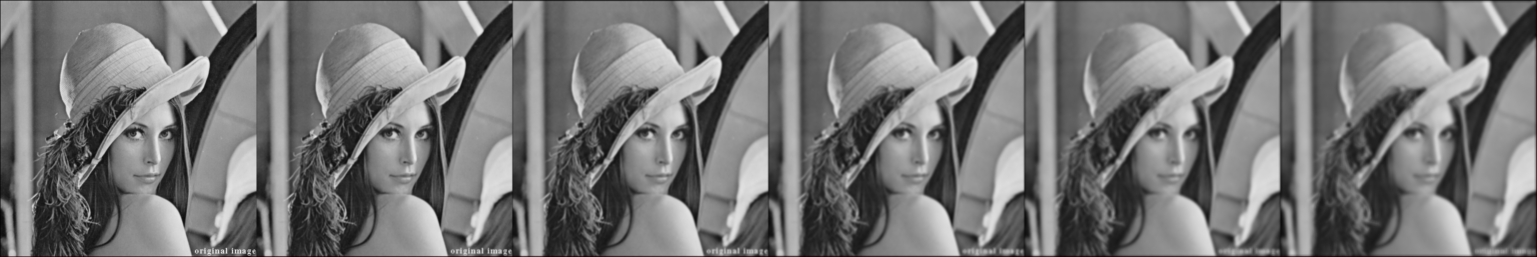

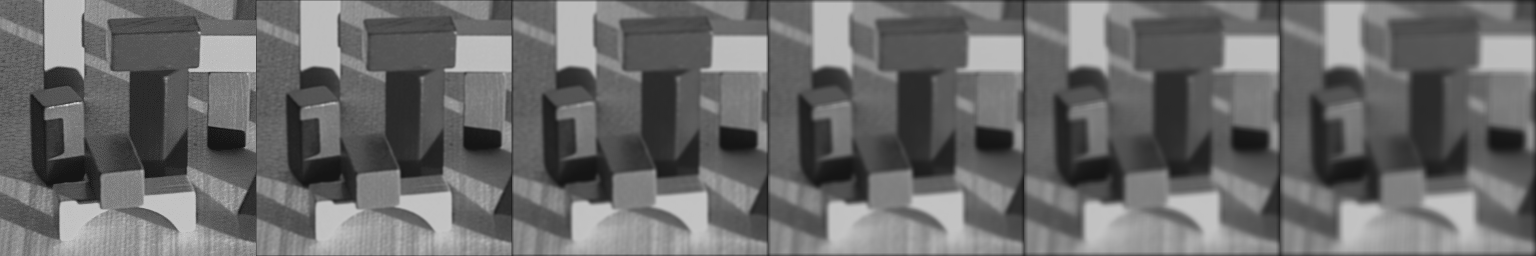

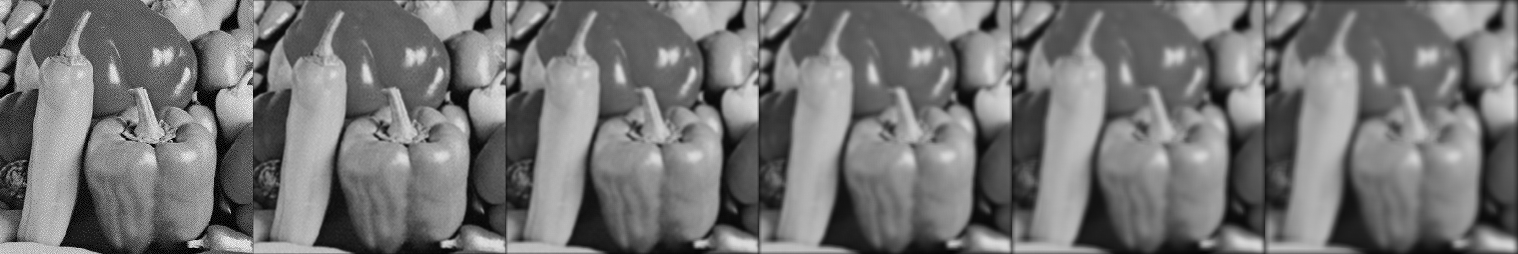

In [45]:
let 
    paths = ["act1/lena.ppm", "act1/blocks.ppm", "act1/fruit.ppm"];
    for path in paths
        img = load(path);   
        gray_img = Gray.(img)
        img_chn = channelview(gray_img)
        imgs = map((3, 5, 7, 9, 11)) do n
            kernel = generate_kernel(n)
            convolution2D(gray_img, kernel, n)
        end
        display(mosaicview(gray_img, imgs...; nrow=1))
        #display(mosaicview(img, colorview.(RGB, imgs)...; nrow=1))
    end
end

> ## Segunda questão

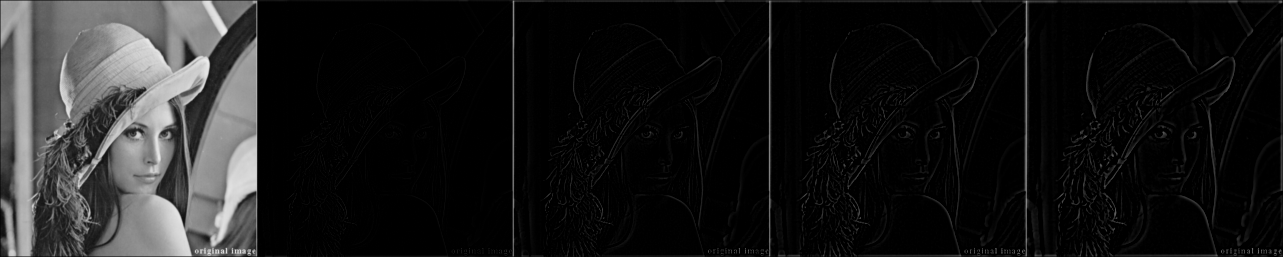

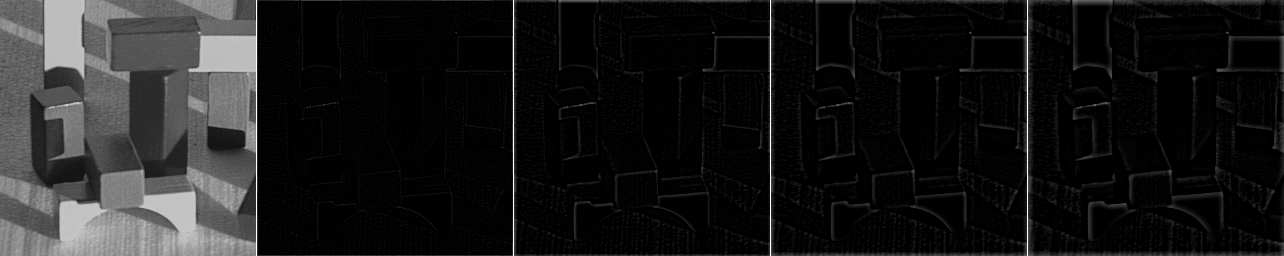

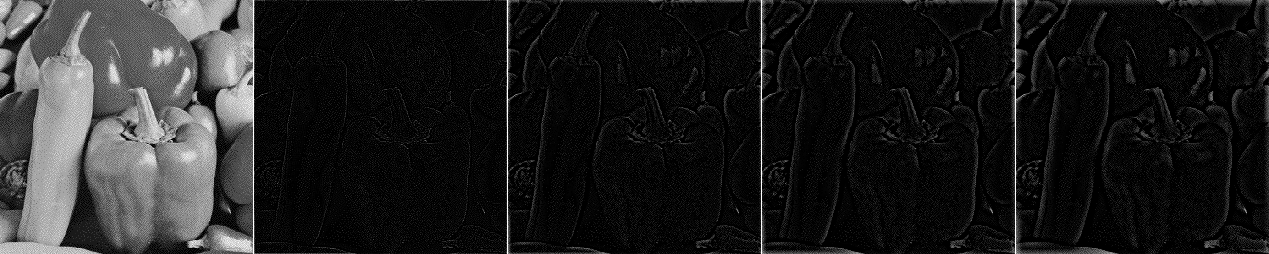

(nothing, nothing, nothing)

In [57]:
let 
    map(("act1/lena.ppm", "act1/blocks.ppm", "act1/fruit.ppm")) do img
        gray_img = load(img) .|> Gray
        img_chn = channelview(gray_img)
        imgs = map((3, 6, 9, 12)) do n
            kernel = high_pass(n)
            convolution2D(float.(gray_img), kernel, n)
        end
        display(mosaicview(gray_img, imgs...; nrow=1, npad=1, fillvalue=1))
    end
end

> ##### Comentários
Um dos efeitos perceptíveis é que, com o aumento do kernel, os pixeis vizinhos do central começam a ter mais realce, o que ocasiona a propagação de realce nas bordas ou até mesmo de ruídos. Portanto, aumento substancial do kernel pode ter efeitos indesejados, já o que o ruído pode propagar mais e efeito de suavização.

> ## Terceira questão

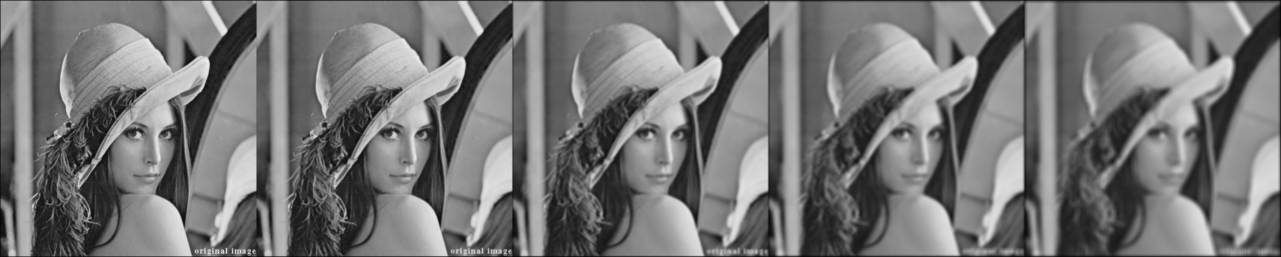

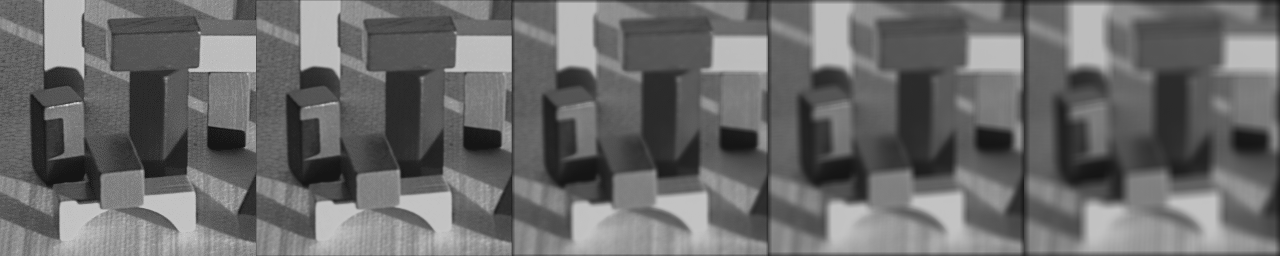

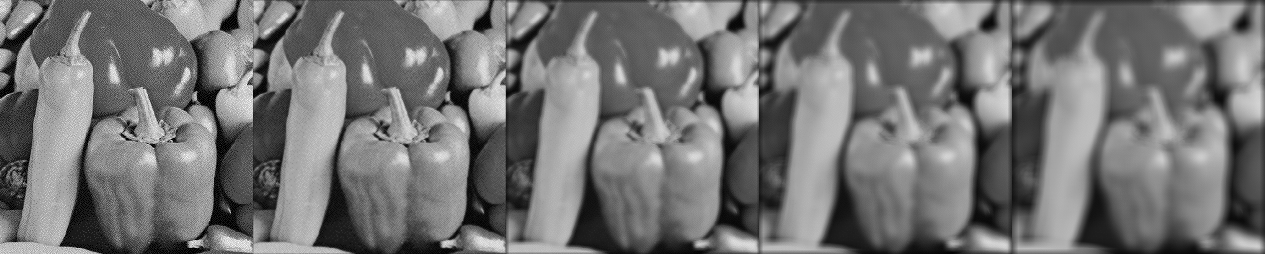

(nothing, nothing, nothing)

In [58]:
let 
    map(("act1/lena.ppm", "act1/blocks.ppm", "act1/fruit.ppm")) do img
        gray_img = load(img) .|> Gray
        img_chn = channelview(gray_img)
        imgs = map((3, 6, 9, 12)) do n
            kernel = low_pass(n)
            convolution2D(gray_img, kernel, n)
        end
        display(mosaicview(gray_img, imgs...; nrow=1))
    end
end

> ##### Comentários
Valor de n tem efeito na suavização da img filtrada. Quanto maior for o n, mais suave a img se torna, ou seja, mais borrada torna-se a img.

> ## Quarta questão

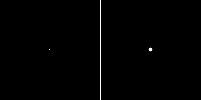

In [53]:
let 
    g = [1/273 4/273 7/273 4/273 1/273;
    4/273 16/273 26/273 16/273 4/273;
    7/273 26/273 41/273 26/273 7/273;
    4/273 16/273 26/273 16/273 4/273;
    1/273 4/273 7/273 4/273 1/273]
    n = 100
    center = div(n, 2)
    img_I = -1 * ones(n, n)
    img_I[center, center] = center

    res = convolution2D(img_I, g, 5)
    mosaicview(Gray.(img_I), res; nrow=1, npad=1, fillvalue=1)
end

> ## Quinta questão

In [8]:
function mean_filter(ref)
    m, n = size(ref)
    img = deepcopy(ref)
    for i in 2:m-1
        for j in 2:n-1
            img[i, j] = mean(ref[i-1:i+1, j-1:j+1])            
        end        
    end 
    
    return img
end

mean_filter (generic function with 1 method)

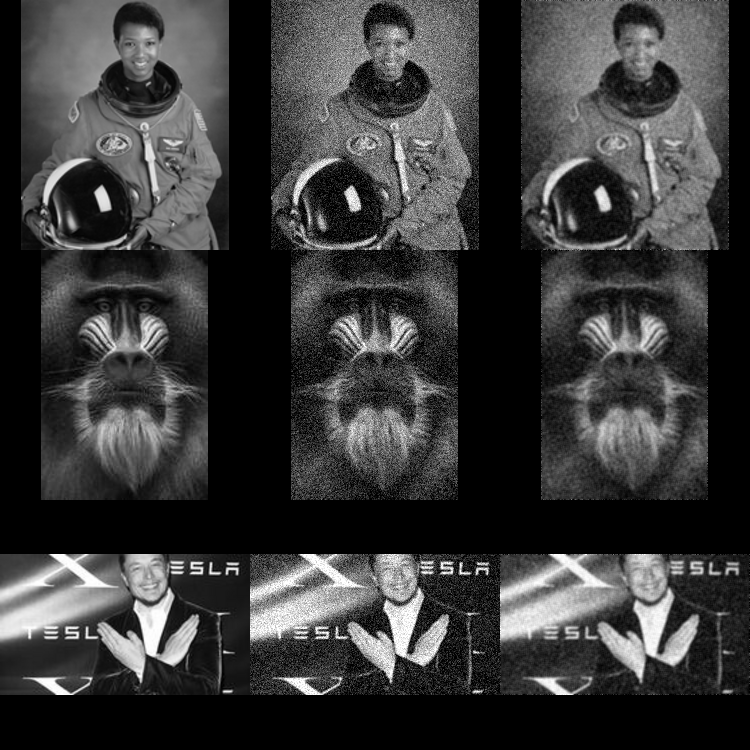

In [9]:
let 
    org_imgs = []
    gau_nois = []
    fil_imgs = map(("jemison.png", "mandrill.png", "musk.png")) do img
        gray_img = load(img) .|> Gray
        push!(org_imgs, gray_img)
        img_g = add_gauss(gray_img) #add ruido gaussiano
        push!(gau_nois, img_g)
        mean_filter(img_g)
    end

    mosaicview(org_imgs..., gau_nois..., fil_imgs...; nrow=3)
end

> ## Sexta questão

In [4]:
import OpenCV as cv

> #### 1 - Variando threshold1

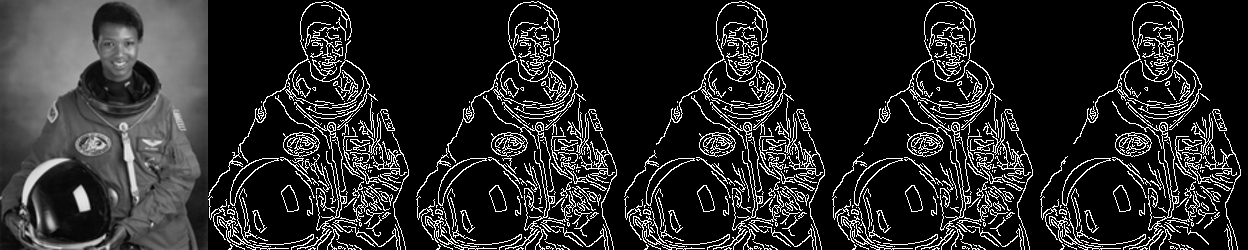

In [18]:

let
    list = map((10., 20., 30., 40., 50.)) do thresh
        img = cv.imread("jemison.png")

        gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        edges = cv.Canny(gray_img, thresh, 150.0)
        edges = colorview(Gray, float.(edges[1,:,:]./255)) |> permutedims
    end

    gray_img = colorview(Gray, float.(gray_img[1,:,:]./255)) |> permutedims
    mosaic(gray_img, list..., nrow=1)
end

> ##### Comentários - Threshold1
O Threshold1 define o limiar menor a ser usado para determinar os gradientes que são calculados pelo operador do sobel. Se o gradiente em um ponto for menor que o limiar, então é considerado uma aresta fraca. Portanto, aumentando o valor Threshold1, a tendência é um equilibrio para arestas que realmente são de interesse. O aumento substâncial pode levar a perda dos detalhes. Observa-se nas imagens da esquerda para direita, algumas ligeiras diferenças, porém, percebe-se que fazem diferença são preservadas.

> #### 2 - Variando threshold2

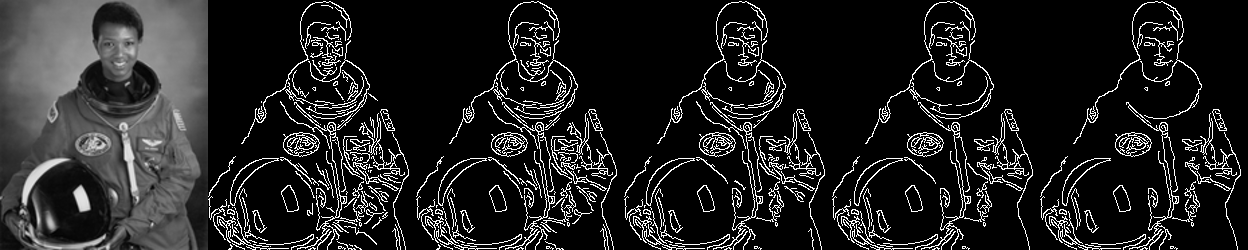

In [29]:

let
    list = map((150., 200., 250., 300., 350.)) do thresh
        img = cv.imread("jemison.png")

        gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        edges = cv.Canny(gray_img, 50., thresh)
        edges = colorview(Gray, float.(edges[1,:,:]./255)) |> permutedims
    end

    gray_img = colorview(Gray, float.(gray_img[1,:,:]./255)) |> permutedims
    mosaic(gray_img, list..., nrow=1)
end

> ##### Comentários - Threshold2
O Threshold2 define o limiar maior a ser usado para determinar os gradientes que são calculados pelo operador do sobel. Se o gradiente em um ponto for maior que o limiar, então é considerado uma aresta forte. Portanto, aumentando o valor Threshold2, mais arestas consideradas fracas serão descartadas. Como pode se observar na imagem, mais detalhes começam desaparecer da esquerda para direita.

> ### 3 - Variando tamanho de abertura

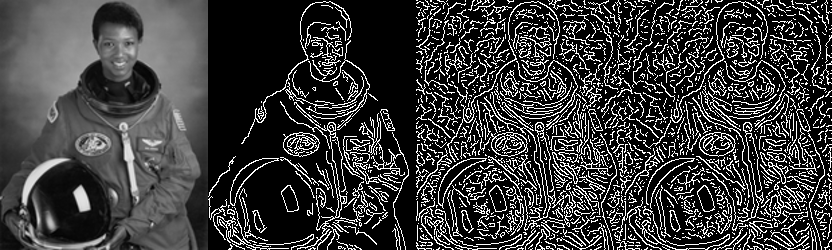

In [30]:
let
    list = map((3, 5, 7)) do apertureSize
        img = cv.imread("jemison.png")

        gray_img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
        edges = cv.Canny(gray_img, 50., 150., apertureSize = apertureSize)
        edges = colorview(Gray, float.(edges[1,:,:]./255)) |> permutedims
    end

    gray_img = colorview(Gray, float.(gray_img[1,:,:]./255)) |> permutedims
    mosaic(gray_img, list..., nrow=1)
end

> ##### Comentários - Aperture
O param aperture define a abertura da janela a ser usado para calcular gradiente usando (operador do sobel). Portanto, com aumento do valor, as bordas começam a perder alguns detalhes mais pequenos, como podemos observar nas duas imagem da direita.

> ## Sétima questão

In [26]:
using ImageFiltering

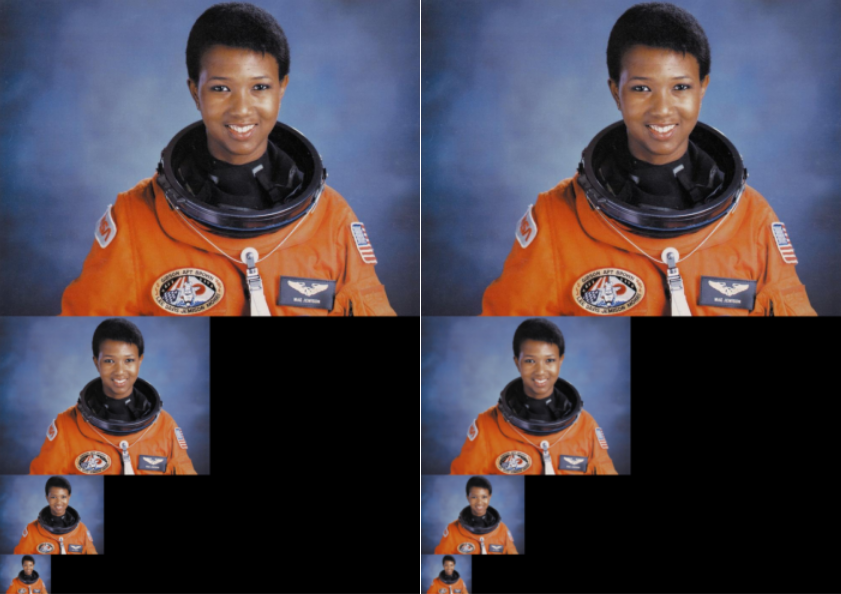

In [31]:
let
function pyramid_down(image, level=4)
    pyramid = []
    for n in 1:level 
        aux = imresize(image, (div(size(image, 2), 2), div(size(image, 1), 2)))
        push!(pyramid, aux)
    end
    return pyramid
end

function pyramid_gaussian(image, level=4)
    pyramid = []
    for n in level
        blurred = imfilter(image, Kernel.gaussian(3))
        blurred = imresize(blurred, (div(size(image, 2), 2), div(size(image, 1), 2))) 
        push!(pyramid, blurred)       
    end
end

function concate_imgs(imgs)
    max_width = maximum(size(img, 2) for img in imgs)
    concated_img = zeros(Float64, sum(size(img, 1) for img in imgs), max_width, 3)
    
    current_y = 1
    for img in imgs
        concated_img[current_y:current_y+size(img, 1)-1, 1:size(img, 2), :] .= img
        current_y += size(img, 1)
    end
    
    return concated_img
end

img = load("act1/jemisson.jpg")
downsamp_pyramid = pyramid_down(img)
gaussian_pyramid = pyramid_gaussian(img)
downsamp_pyramid = concate_imgs(downsamp_pyramid)
gaussian_pyramid = concate_imgs(gaussian_pyramid)
#downsamp_pyramid = permutedims(downsamp_pyramid, [3, 1, 2])
#gaussian_pyramid = permutedims(gaussian_pyramid, [3, 1, 2])
mosaicview(downsamp_pyramid, gaussian_pyramid; nrow=1)
end

#### Em jeito de comparação, o que se percebe é que a aplicação direta de downsample introduz ligeiramente a distorção (aliasing), pelo fato de resizing sucessiva, o que faz a imagem perder alguns detalhes.
#### Por outro lado, a aplicação do filtro gaussiano, que suaviza antes de aplicar o downsample, ajuda a preservar mais detalhes. 

> ## Oitava questão

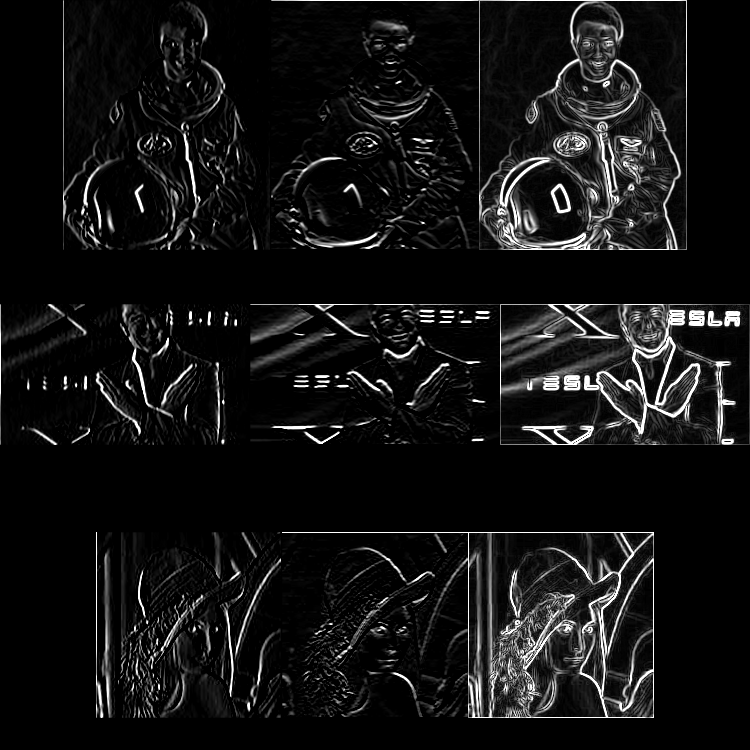

In [69]:
function x_derivative(img)
    kernel = [-1 0 1; -1 0 1; -1 0 1]
    return convolution2D(img, kernel, 3)
end

function y_derivative(img)
    kernel = [-1 -1 -1; 0 0 0; 1 1 1]
    return convolution2D(img, kernel, 3)
end

function gradient_mod(img)
    derivada_x = x_derivative(img)
    derivada_y = y_derivative(img)
    gradiente = sqrt.(derivada_x .^ 2 + derivada_y .^ 2)
    return gradiente
end
let
    imgs = map(("jemison.png", "musk.png", "lena.jpeg")) do name
        img = Gray.(load(name))
        chan = channelview(img)
        der_x = x_derivative(float.(chan))
        der_y = y_derivative(float.(chan))
        mod_grad = gradient_mod(float.(chan))
        hcat(Gray.(der_x), Gray.(der_y), Gray.(mod_grad))
    end

    mosaicview(imgs..., nrow=3)
end

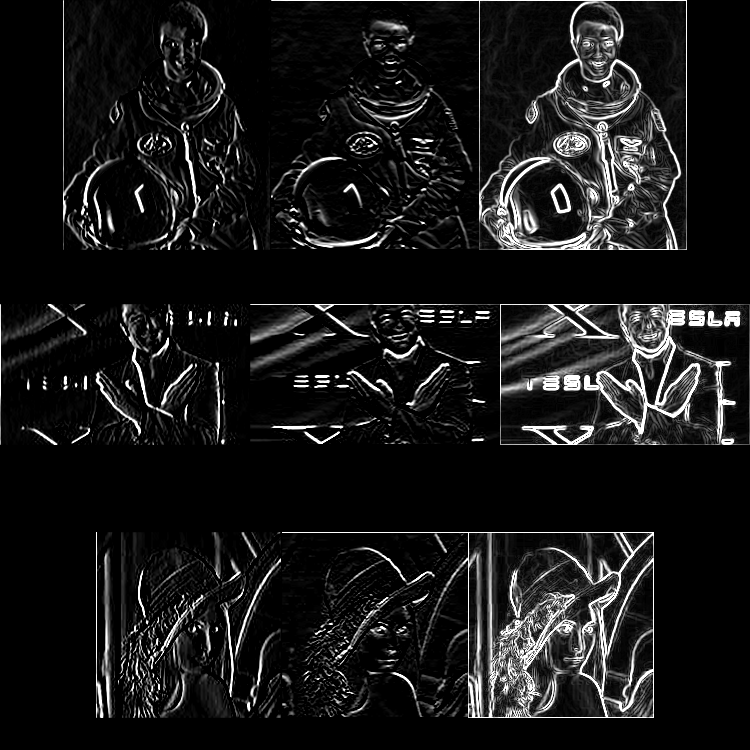

In [71]:
function sobel_operator(img)
    kernel_x = [-1 0 1; -2 0 2; -1 0 1]
    kernel_y = [-1 -2 -1; 0 0 0; 1 2 1]
    
    der_x = convolution2D(img, kernel_x, 3)
    der_y = convolution2D(img, kernel_y, 3)
    
    mod_grad = sqrt.(der_x .^ 2 + der_y .^ 2)
    
    return hcat(Gray.(der_x), Gray.(der_y), Gray.(mod_grad))
end

let
    imgs = map(("jemison.png", "musk.png", "lena.jpeg")) do name
        img = Gray.(load(name))
        chan = channelview(img)

        sobel_operator(float.(chan))
    end

    mosaicview(imgs..., nrow=3)
end